In [19]:
%load_ext autoreload
%autoreload 2

# Import Deps

In [1]:
!pip install librosa

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
import librosa

# torch
import torch
import torchaudio
from torch.utils.data import DataLoader

# model training
from cnn import CNNetwork
from dataset import VoiceDataset

# Test Dataset

In [4]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device.")

Using cpu device.


In [5]:
DATA_PATH = os.path.join('..', 'data')
TEST_PATH = os.path.join(DATA_PATH, 'test')
SAMPLE_RATE = 48000
MEL_SPEC = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=2048,
    hop_length=512,
    n_mels=128
)

In [6]:
test_dataset = VoiceDataset(TEST_PATH, MEL_SPEC, device, SAMPLE_RATE)

## Choose Example

In [7]:
len(test_dataset)

19

In [8]:
i = 0
test_dataset[i][1]

0

In [9]:
test_dataset.label_mapping

{'aman': 0, 'imran': 1, 'labib': 2}

In [31]:
wav, actual_output = test_dataset[i]

## Show Example Spec

In [11]:
def plot_waveform(waveform, sample_rate, title = "Waveform"):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time = np.arange(0, num_frames) / sample_rate

    fig, axes = plt.subplots(num_channels, 1)

    if num_channels == 1:
        axes = [axes]
    for ch in range(num_channels):
        axes[ch].plot(time, waveform[ch])
        axes[ch].grid(True)

    if num_channels > 1:
        axes[ch].set_ylabel(f"Channel: {ch+1}")
    plt.suptitle(title)
    plt.show(block = False)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [12]:
file, label = test_dataset.audio_files_labels[i]
path = os.path.join(TEST_PATH, label, file)
audio_wavform, sr = torchaudio.load(path)

In [13]:
Audio(audio_wavform, rate=sr)

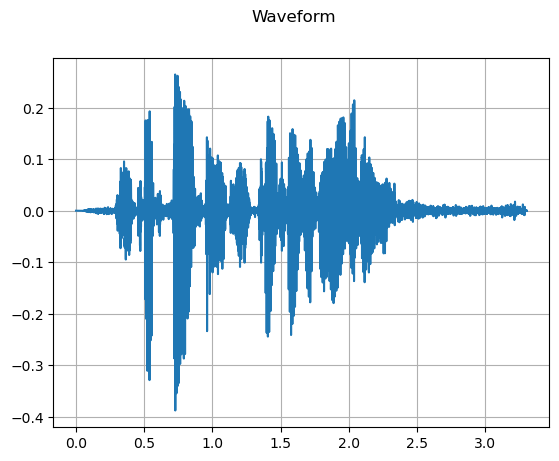

In [14]:
plot_waveform(audio_wavform, sr)

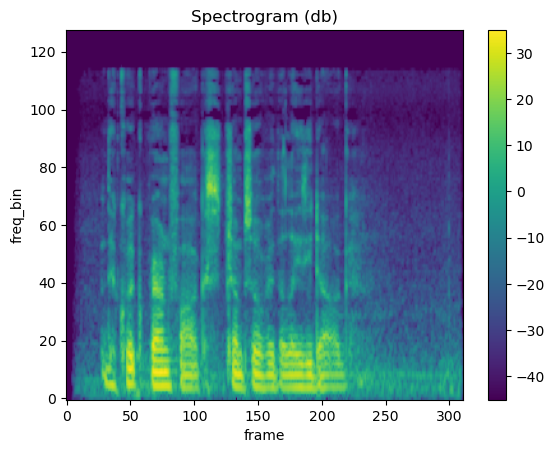

In [15]:
plot_spectrogram(MEL_SPEC(audio_wavform).squeeze(0))

# Model

In [20]:
model = CNNetwork().to(device)
state_dict = torch.load("../models/void_demo.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [21]:
print(model)

CNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=35712, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [46]:
input = wav.unsqueeze(0)
output = model(input)
prediction = torch.argmax(output, 1).item()
prediction

0

In [49]:
actual_output == prediction

True